# CrowdTruth for Free Input Tasks: Person Annotation in Video

In this tutorial, we will apply CrowdTruth metrics to a **free input** crowdsourcing task for **Person Annotation** from **video fragments**. The workers were asked to watch a video of about 3-5 seconds and then add tags that are relevant for the people that appear in the video fragment. The task was executed on [FigureEight](https://www.figure-eight.com/).

To replicate this experiment, the code used to design and implement this crowdsourcing annotation template is available here: [template](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Free/template.html), [css](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Free/template.css), [javascript](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Free/template.js). 

This is a screenshot of the task as it appeared to workers:

![Task Template](img/person-video-free-input.png)

A sample dataset for this task is available in [this file](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/data/person-video-free-input.csv), containing raw output from the crowd on FigureEight. Download the file and place it in a folder named `data` that has the same root as this notebook. Now you can check your data:

In [1]:
import pandas as pd

test_data = pd.read_csv("data/person-video-free-input.csv")
test_data.head()

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,...,e_volumechange_gold,e_waiting_gold,hiddeninput_gold,imagelocation,imagetags,keyframeid_gold,keywords_gold,subtitles,subtitletags,videolocation
0,1856665485,9/1/2018 18:50:31,4023167828,9/1/2018 18:50:04,False,prodege,1,3587109,CAN,NS,...,NaN,NaN,NaN,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
1,1856665485,9/1/2018 19:14:27,4023199796,9/1/2018 19:11:49,False,prodege,1,11131207,CAN,ON,...,NaN,NaN,NaN,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
2,1856665485,9/1/2018 19:14:27,4023199802,9/1/2018 19:14:02,False,elite,1,44242038,USA,FL,...,NaN,NaN,NaN,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
3,1856665485,9/1/2018 20:00:28,4023268757,9/1/2018 19:59:35,False,keeprewarding,1,44637936,CAN,NS,...,NaN,NaN,NaN,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
4,1856665485,9/1/2018 20:59:38,4023382276,9/1/2018 20:58:37,False,elite,1,43852630,USA,FL,...,NaN,NaN,NaN,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

import crowdtruth
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Person Type/Role Annotation in Video task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`annotation_separator`:** string that separates between the crowd annotations in `outputColumns`
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is the list of relations
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

Same examples of possible processing functions of crowd answers are given below:

In [32]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from autocorrect import spell

def correct_words(keywords, separator):
    keywords_list = keywords.split(separator)
    corrected_keywords = []
    
    for keyword in keywords_list:
        
        words_in_keyword = keyword.split(" ")
        corrected_keyword = []
        for word in words_in_keyword:
            correct_word = spell(word)
            corrected_keyword.append(correct_word)
        corrected_keywords.append(" ".join(corrected_keyword))
    return separator.join(corrected_keywords)
    
def cleanup_keywords(keywords, separator):
    keywords_list = keywords.split(separator)
    stopset = set(stopwords.words('english'))
    
    filtered_keywords = []
    for keyword in keywords_list:
        tokens = nltk.word_tokenize(keyword)
        cleanup = " ".join(filter(lambda word: str(word) not in stopset or str(word) == "no" or str(word) == "not", keyword.split()))
        filtered_keywords.append(cleanup)
    return separator.join(filtered_keywords)

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_keywords(keywords, separator):
    keywords_list = keywords.split(separator)
    lematized_keywords = []
    
    for keyword in keywords_list:
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(str(keyword)))  
        wn_tagged = map(lambda x: (str(x[0]), nltk2wn_tag(x[1])), nltk_tagged)
        res_words = []
        for word, tag in wn_tagged:
            if tag is None:            
                res_word = wordnet._morphy(str(word), wordnet.NOUN)
                if res_word == []:
                    res_words.append(str(word))
                else:
                    if len(res_word) == 1:
                        res_words.append(str(res_word[0]))
                    else:
                        res_words.append(str(res_word[1]))
            else:
                res_word = wordnet._morphy(str(word), tag)
                if res_word == []:
                    res_words.append(str(word))
                else: 
                    if len(res_word) == 1:
                        res_words.append(str(res_word[0]))
                    else:
                        res_words.append(str(res_word[1]))
        lematized_keyword = " ".join(res_words)
        lematized_keywords.append(lematized_keyword)
        
    return separator.join(lematized_keywords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oanainel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/oanainel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oanainel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oanainel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The complete configuration class is declared below:

In [33]:
class TestConfig(DefaultConfig):
    inputColumns = ["videolocation", "subtitles", "imagetags", "subtitletags"]
    outputColumns = ["keywords"]
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = []
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[]','no tags'))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            # remove the quotes around the annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('"',''))
            # apply custom processing functions
            judgments[col] = judgments[col].apply(lambda x: correct_words(str(x), self.annotation_separator))
            judgments[col] = judgments[col].apply(lambda x: "no tag" if cleanup_keywords(str(x), self.annotation_separator) == '' else cleanup_keywords(str(x), self.annotation_separator))
            judgments[col] = judgments[col].apply(lambda x: lemmatize_keywords(str(x), self.annotation_separator))
        return judgments

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [31]:
data, config = crowdtruth.load(
    file = "data/person-video-free-input.csv",
    config = TestConfig()
)

data['judgments'].head()

INFO:root:Config loaded
INFO:root:Values not stored as dictionary


,output.keywords,output.keywords.count,output.keywords.unique,submitted,started,worker,unit,duration,job
judgment,,,,,,,,,
4023167828,"{u'space': 1, u'astronaut': 1}",2,2,2018-09-01 18:50:31,2018-09-01 18:50:04,3587109,1856665485,27,data/person-video-free-input
4023199796,{u'astronaut': 1},1,1,2018-09-01 19:14:27,2018-09-01 19:11:49,11131207,1856665485,158,data/person-video-free-input
4023199802,"{u'astronaut': 1, u'italian': 1, u'Samantha': ...",5,5,2018-09-01 19:14:27,2018-09-01 19:14:02,44242038,1856665485,25,data/person-video-free-input
4023268757,"{u'astronaut': 1, u'float': 1}",2,2,2018-09-01 20:00:28,2018-09-01 19:59:35,44637936,1856665485,53,data/person-video-free-input
4023382276,{u'zero gravity': 1},1,1,2018-09-01 20:59:38,2018-09-01 20:58:37,43852630,1856665485,61,data/person-video-free-input


## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics:

In [34]:
results = crowdtruth.run(data, config)

INFO:root:1 iterations; max d= 1.0 ; wqs d= 0.93410171551; uqs d= 0.837809124823; aqs d= 0.0
INFO:root:2 iterations; max d= 0.49025890176 ; wqs d= 0.20902623628; uqs d= 0.064296828401; aqs d= 0.0
INFO:root:3 iterations; max d= 505583424.09 ; wqs d= 212663404.835; uqs d= 0.0385917665451; aqs d= 0.0
INFO:root:4 iterations; max d= 505583423.739 ; wqs d= 212663404.564; uqs d= 0.0253326470826; aqs d= 0.0
INFO:root:5 iterations; max d= 0.245379004549 ; wqs d= 0.131751722603; uqs d= 0.0221470600619; aqs d= 0.0
INFO:root:6 iterations; max d= 53183306.1319 ; wqs d= 11461658.0189; uqs d= 499603.867815; aqs d= 0.0
INFO:root:7 iterations; max d= 3.07505663403e+21 ; wqs d= 5.35023742944e+18; uqs d= 1.61932391328e+20; aqs d= 0.0
INFO:root:8 iterations; max d= 3.45703553128e+51 ; wqs d= 6.06497461628e+49; uqs d= 1.63416950401e+27; aqs d= 0.0
INFO:root:9 iterations; max d= 9.47508811577e+102 ; wqs d= 1.66229616066e+101; uqs d= 1.71022308958e+88; aqs d= 0.0
INFO:root:10 iterations; max d= 2.17126875068

`results` is a dict object that contains the quality metrics for the video fragments, annotations and crowd workers.

The **video fragment metrics** are stored in `results["units"]`:

In [35]:
results["units"]["output.keywords"][1856665496]

Counter({'academic': 1,
         'color': 1,
         'discussion': 1,
         'girl': 1,
         'graphic': 1,
         'innovation': 1,
         'invisible': 1,
         'letter': 1,
         'makeover': 2,
         'man': 1,
         'movie': 1,
         'narrator': 1,
         'no person': 2,
         'no tag': 1,
         'none': 7,
         'not present': 1,
         'party': 1,
         'person': 1,
         'rectangle': 1,
         'shes': 1,
         'speak': 1,
         'squiggle': 1,
         'title': 1,
         'triangle': 1})

The `uqs` column in `results["units"]` contains the **video fragment quality scores**, capturing the overall workers agreement over each video fragment. Here we plot its histogram:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results["units"]["uqs"])
plt.xlabel("Video Fragment Quality Score")
plt.ylabel("Video Fragment")

The `unit_annotation_score` column in `results["units"]` contains the **video fragment-annotation scores**, capturing the likelihood that an annotation is expressed in a video fragment. For each video fragment, we store a dictionary mapping each annotation to its video fragment-relation score.

In [ ]:
results["units"]["unit_annotation_score_initial"].head()

The **worker metrics** are stored in `results["workers"]`:

In [46]:
results["workers"].head()

,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
1855113,43.60,1,25,25,0.636597,0.734697,0.866475,0.324769,0.474289,0.684750
3587109,15.40,1,25,25,0.411768,0.581163,0.708524,0.366236,0.499577,0.733092
4316379,36.76,1,25,25,0.446025,0.638058,0.699036,0.191752,0.370894,0.516999
6339764,79.28,1,25,25,0.176038,0.423132,0.416035,0.231437,0.387467,0.597309
6367365,53.08,1,25,25,0.508121,0.668064,0.760587,0.280973,0.436799,0.643254


The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.

Text(0,0.5,u'Workers')

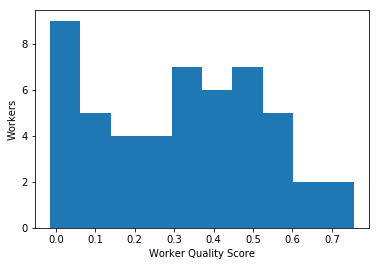

In [47]:
plt.hist(results["workers"]["wqs"])
plt.xlabel("Worker Quality Score")
plt.ylabel("Workers")

The **annotation metrics** are stored in `results["annotations"]`. The `aqs` column contains the **annotation quality scores**, capturing the overall worker agreement over one relation.

In [14]:
results["annotations"]

,output.selected_answer,aqs,aqs_initial
archeologist,1000,1.000000e-08,1.000000e-08
architect,1000,1.000000e-08,1.000000e-08
artist,1000,2.512851e-01,2.520942e-01
astronaut,1000,9.999680e-01,9.523810e-01
athlete,1000,2.801650e-01,2.788104e-01
businessperson,1000,6.188727e-02,9.618163e-02
celebrity,1000,7.459197e-01,6.066316e-01
chef,1000,1.000000e-08,1.000000e-08
criminal,1000,1.272384e-01,1.530612e-01
engineer,1000,3.608684e-02,2.991453e-02
